# Generate charts for trading analysis using RDP Historical Pricing data

## Overview

Technical Analysis for intraday trading is one of the basic approaches to help you choose the planning of ventures. Basically, users can use the intraday or end-of-day pricing data to generate charts such as the CandleStick. And then, they can review the stock price' trend and make decisions using their own mehtod or algorithm. Typically, Refinitiv Workspace and Eikon Desktop users also provide access to this information, and it also provides a user interface to display multiple types of Charts. 

However, there is a specific requirement from a customer who did not use Eikon or Refinitiv Workspace. They need to build their own stand-alone application or generate the charts on their application using data from Refintiv. The user is looking for the source of data or service to provide the intraday data for them in the REST API format. So they can integrate the service with their app. 

To support the requirement client can use REST API provided by [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) that basically provides simple web-based API access to a broad range of content provided by Refinitiv. It can retrieve data such as News, ESG, Symbology, Streaming Price, and Historical Pricing. Users can get the intraday from the Historical Pricing service and then pass the data to any libraries that provided functionality to generate Charts. To help API users access RDP content easier, Refinitiv also provides the Refinitiv Data Platform (RDP) Libraries that provide a set of uniform interfaces providing the developer access to the Refinitiv Data Platform. We are currently providing an RDP Library for Python and .NET users. A general user and data scientists can leverage the library's functionality to retrieve data from the service, which basically provides the original response message from the RDP service in JSON tabular format. The RDP Library for Python will then convert the JSON tabular format to the pandas dataframe so that the user does not need to handle a JSON message and convert it manually. The user can use the dataframe with libraries such as mathplotlib and mplfinance to display the Charts.


In this example, I will show you how to use RDP Library for Python, request the intraday data from the Historical Pricing service, and then generate basic charts such as the Candle Stick charts. Basically, the [Japanese candlestick chart](https://www.investopedia.com/trading/candlestick-charting-what-is-it/) commonly used to illustrate movements in the price of a financial instrument over time. It's popular in finance, and some technical analysis strategies use them to make trading decisions, depending on the candles' shape, color, and position.

## Prerequisites

* Follow instructions from [Quick Start Guide](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start) to install RDP Library for python.

    ```bash
    > pip install refinitiv.dataplatform
    ```

* You must have RDP Account with permission to request data using Historical Pricing API. You can also login to [APIDocs page](https://apidocs.refinitiv.com/Apps/ApiDocs). Then you can search for the Historical Pricing and looking at section Reference for the document.

* Ensure that you have the following additional python libraries.

  ```bash
  configparser, matplotlib,mplfinance
  ```
  


## Getting Started using RDP API for python

I will create a configuration file to keep the RDP user info and read it using ConfigParser. This module provides a class that implements a basic configuration language that provides a structure similar to what’s found in Microsoft Windows INI files. We will start creating a configuration file name rdp_cofig.cfg. It will contain the rdpuser section, which use to keep app_key, username, and password.

Below is a sample configuration file you must create.

```bash
[rdpuser]
app_key =  <Appkey/ClientId>
username = <RDP User>
password = <RDP Password>
```

### Open the Platform Session

Next step, we will import __[refinitiv.dataplatform](https://pypi.org/project/refinitiv-dataplatform/)__ library and pass RDP user to function __open_platform_session__ to open a session to the RDP server. RDP library will handle the authorization and manage the session for you.

In [7]:
import refinitiv.dataplatform as rdp
import configparser as cp

global session
global ricName

session=None

cfg = cp.ConfigParser()
#change cfgpath to your own path on your OS.
cfgpath= './rdp_config.cfg'
if not cfg.read(cfgpath) :
    print(f'Unable to read the configuration file')
else:

    print(f"RDP Version {rdp.__version__}")

    # Open RDP Platform Session
    print("Open Platform Session")
    session = rdp.open_platform_session(cfg['rdpuser']['app_key'],rdp.GrantPassword(username = cfg['rdpuser']['username'],password = cfg['rdpuser']['password']))

    print(f"RDP Sesssion State is now {session.get_open_state()}")

RDP Version 1.0.0a7
Open Platform Session
RDP Sesssion State is now State.Open


### Retreive Time Series data from RDP

After the session state is Open, we will use the below get_historical_price_summaries interface to retrieve time series pricing Interday summaries data(i.e., bar data).

```python
get_historical_price_summaries(universe, interval=None, start=None, end=None, adjustments=None, sessions=[], count=1, fields=[], on_response=None, closure=None)
```

Actually, the implementation of this function will send HTTP GET requests to the following RDP endpoint.

```python
https://api.refinitiv.com/data/historical-pricing/v1/views/interday-summaries/
```

And the following details are possible values for interval and adjustment arguments.

Supported __intervals__:
Intervals.DAILY, Intervals.WEEKLY, Intervals.MONTHLY, Intervals.QUARTERLY, Intervals.YEARLY.

Supported value for __adjustments__:
'unadjusted', 'exchangeCorrection', 'manualCorrection', 'CCH', 'CRE', 'RPO', 'RTS', 'qualifiers'

You can pass an array of these values to the function like the below sample codes.

```python
adjustments=['unadjusted']
adjustments=['unadjusted','CCH','CRE','RPO','RTS']
```

Please find below details regarding the adjustments behavior; it's the details from a reference section on the APIDocs page. Note that it can be changed in future releases. I would suggest you leave it to the default value.

The adjustments are a query parameter that tells the system whether to apply or not apply CORAX (Corporate Actions) events or exchange/manual corrections or price and volume adjustment according to trade/quote qualifier summarization actions to historical time series data.

Normally, the back-end should strictly serve what clients need. However, if the back-end cannot support them, the back-end can still return the form that the back-end supports with the proper adjustments in the response and status block (if applicable) instead of an error message.

Limitations: Adjustment behaviors listed in the limitation section may be changed or improved in the future.

1. If any combination of correction types is specified (i.e., exchangeCorrection or manualCorrection), all correction types will be applied to data in applicable event types.

2. If any combination of CORAX is specified (i.e., CCH, CRE, RPO, and RTS), all CORAX will be applied to data in applicable event types.

Adjustments values for Interday-summaries and Intraday-summaries API

If unspecified, each back-end service will be controlled with the proper adjustments in the response so that the clients know which adjustment types are applied by default. In this case, the returned data will be applied with exchange and manual corrections and applied with CORAX adjustments.

If specified, the clients want to get some specific adjustment types applied or even unadjusted.

The supported values of adjustments:

* exchangeCorrection - Apply exchange correction adjustment to historical pricing
* manualCorrection - Apply manual correction adjustment to historical pricing, i.e., annotations made by content analysts
* CCH - Apply Capital Change adjustment to historical Pricing due to Corporate Actions, e.g., stock split
* CRE - Apply Currency Redenomination adjustment when there is redenomination of the currency
* RTS - Apply Reuters TimeSeries adjustment to adjust both historical price and volume
* RPO - Apply Reuters Price Only adjustment to adjust historical price only, not volume
* unadjusted - Not apply both exchange/manual correct and CORAX

Notes:

1. Summaries data will always have exchangeCorrection and manualCorrection applied. If the request is explicitly asked for uncorrected data, a status block will be returned along with the corrected data saying, "Uncorrected summaries are currently not supported".

2. The unadjusted will be ignored when other values are specified.

Below is a sample code to retrieve Daily historical pricing for the RIC defined in ricName variable, and I will set the start date from 2013 to nowaday. You need to set the interval to rdp.Intervals.DAILY to get intraday data. We will display the columns name with the heads and tails of the dataframe to review the data.


In [8]:
import pandas as pd
import datetime
from IPython.display import clear_output

ricName='MSFT.O'
StartDate = '2010.01.01'
EndDate = str(datetime.date.today())

if session != None : 
    data = rdp.get_historical_price_summaries(
        universe = ricName,
        interval = rdp.Intervals.DAILY,          # Supported intervals: DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY.
        start=StartDate, end= EndDate)

    if data is not None:
        #Show information of the dataframe to see column name , null and null-null field and the data type of the column
        data.info()
        display(data.head)
        display(data.tail)
    else:
        print("Error while process the data")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2796 entries, 2009-12-31 to 2021-02-09
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TRDPRC_1    2796 non-null   float64
 1   HIGH_1      2796 non-null   float64
 2   LOW_1       2796 non-null   float64
 3   ACVOL_UNS   2796 non-null   Int64  
 4   OPEN_PRC    2796 non-null   float64
 5   BID         2796 non-null   float64
 6   ASK         2796 non-null   float64
 7   TRNOVR_UNS  1622 non-null   float64
 8   VWAP        2796 non-null   float64
 9   BLKCOUNT    2796 non-null   Int64  
 10  BLKVOLUM    2796 non-null   Int64  
 11  NUM_MOVES   2344 non-null   Int64  
 12  TRD_STATUS  1400 non-null   Int64  
 13  SALTIM      1388 non-null   Int64  
 14  NAVALUE     0 non-null      object 
dtypes: Int64(6), float64(8), object(1)
memory usage: 365.9+ KB


<bound method NDFrame.head of             TRDPRC_1    HIGH_1   LOW_1  ACVOL_UNS  OPEN_PRC     BID     ASK  \
2009-12-31    30.480   30.9900   30.48   31929611   30.9799   30.48   30.50   
2010-01-04    30.950   31.1000   30.59   38414185   30.6200   30.94   30.95   
2010-01-05    30.960   31.1000   30.64   49758862   30.8500   30.94   30.95   
2010-01-06    30.770   31.0800   30.52   58182332   30.8800   30.76   30.77   
2010-01-07    30.452   30.7000   30.19   50564285   30.6300   30.47   30.48   
...              ...       ...     ...        ...       ...     ...     ...   
2021-02-03   243.000  245.0900  239.26   27158104  239.5700  242.94  243.00   
2021-02-04   242.010  243.2399  240.37   25296100  242.6600  241.91  242.12   
2021-02-05   242.200  243.2800  240.42   18054752  242.2300  242.20  242.22   
2021-02-08   242.470  243.6800  240.81   22211929  243.1500  242.47  242.52   
2021-02-09   243.770  244.7600  241.38   23564953  241.8700  243.69  243.80   

              TRNOVR_

<bound method NDFrame.tail of             TRDPRC_1    HIGH_1   LOW_1  ACVOL_UNS  OPEN_PRC     BID     ASK  \
2009-12-31    30.480   30.9900   30.48   31929611   30.9799   30.48   30.50   
2010-01-04    30.950   31.1000   30.59   38414185   30.6200   30.94   30.95   
2010-01-05    30.960   31.1000   30.64   49758862   30.8500   30.94   30.95   
2010-01-06    30.770   31.0800   30.52   58182332   30.8800   30.76   30.77   
2010-01-07    30.452   30.7000   30.19   50564285   30.6300   30.47   30.48   
...              ...       ...     ...        ...       ...     ...     ...   
2021-02-03   243.000  245.0900  239.26   27158104  239.5700  242.94  243.00   
2021-02-04   242.010  243.2399  240.37   25296100  242.6600  241.91  242.12   
2021-02-05   242.200  243.2800  240.42   18054752  242.2300  242.20  242.22   
2021-02-08   242.470  243.6800  240.81   22211929  243.1500  242.47  242.52   
2021-02-09   243.770  244.7600  241.38   23564953  241.8700  243.69  243.80   

              TRNOVR_

# Preparing data for plotting chart

Next steps, we will create a new dataframe object from the data returned by the interday-summaries endpoint. We need to map the columns from the original dataframe to Open, High, Low, Close(OHLC) data. So we will define column names to map the OHLC data from the following variables.

```
openColumns =>Open 
highColumns => High
lowColumns => Low 
closeColumns => Close
volumeColums => Volume
```

In [9]:
openColumns="OPEN_PRC"
highColumns="HIGH_1"
lowColumns="LOW_1"
closeColumns="TRDPRC_1"
volumeColumns="ACVOL_UNS"

ohlc_dataframe= data[[openColumns,highColumns,lowColumns,closeColumns,volumeColumns]]
ohlc_dataframe.index.name = 'Date'
display(ohlc_dataframe)
#rename the column name
ohlc_dataframe.info()
ohlc_dataframe=ohlc_dataframe.rename(columns={openColumns:"Open",highColumns:"High",lowColumns:"Low",closeColumns:"Close",volumeColumns:"Volume"})
print(ohlc_dataframe.columns)
display(ohlc_dataframe)


,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,ACVOL_UNS
Date,,,,,
2009-12-31,30.9799,30.9900,30.48,30.480,31929611
2010-01-04,30.6200,31.1000,30.59,30.950,38414185
2010-01-05,30.8500,31.1000,30.64,30.960,49758862
2010-01-06,30.8800,31.0800,30.52,30.770,58182332
2010-01-07,30.6300,30.7000,30.19,30.452,50564285
...,...,...,...,...,...
2021-02-03,239.5700,245.0900,239.26,243.000,27158104
2021-02-04,242.6600,243.2399,240.37,242.010,25296100
2021-02-05,242.2300,243.2800,240.42,242.200,18054752


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2796 entries, 2009-12-31 to 2021-02-09
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OPEN_PRC   2796 non-null   float64
 1   HIGH_1     2796 non-null   float64
 2   LOW_1      2796 non-null   float64
 3   TRDPRC_1   2796 non-null   float64
 4   ACVOL_UNS  2796 non-null   Int64  
dtypes: Int64(1), float64(4)
memory usage: 133.8 KB
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Volume
Date,,,,,
2009-12-31,30.9799,30.9900,30.48,30.480,31929611
2010-01-04,30.6200,31.1000,30.59,30.950,38414185
2010-01-05,30.8500,31.1000,30.64,30.960,49758862
2010-01-06,30.8800,31.0800,30.52,30.770,58182332
2010-01-07,30.6300,30.7000,30.19,30.452,50564285
...,...,...,...,...,...
2021-02-03,239.5700,245.0900,239.26,243.000,27158104
2021-02-04,242.6600,243.2399,240.37,242.010,25296100
2021-02-05,242.2300,243.2800,240.42,242.200,18054752


## Visualizing Stock Data

## Plot a simple Daily Closing Price line graph

We can create a simple line graph to compare open and close price using the following codes. You can change size of figure.figsize to adjust chart size.


<IPython.core.display.Javascript object>


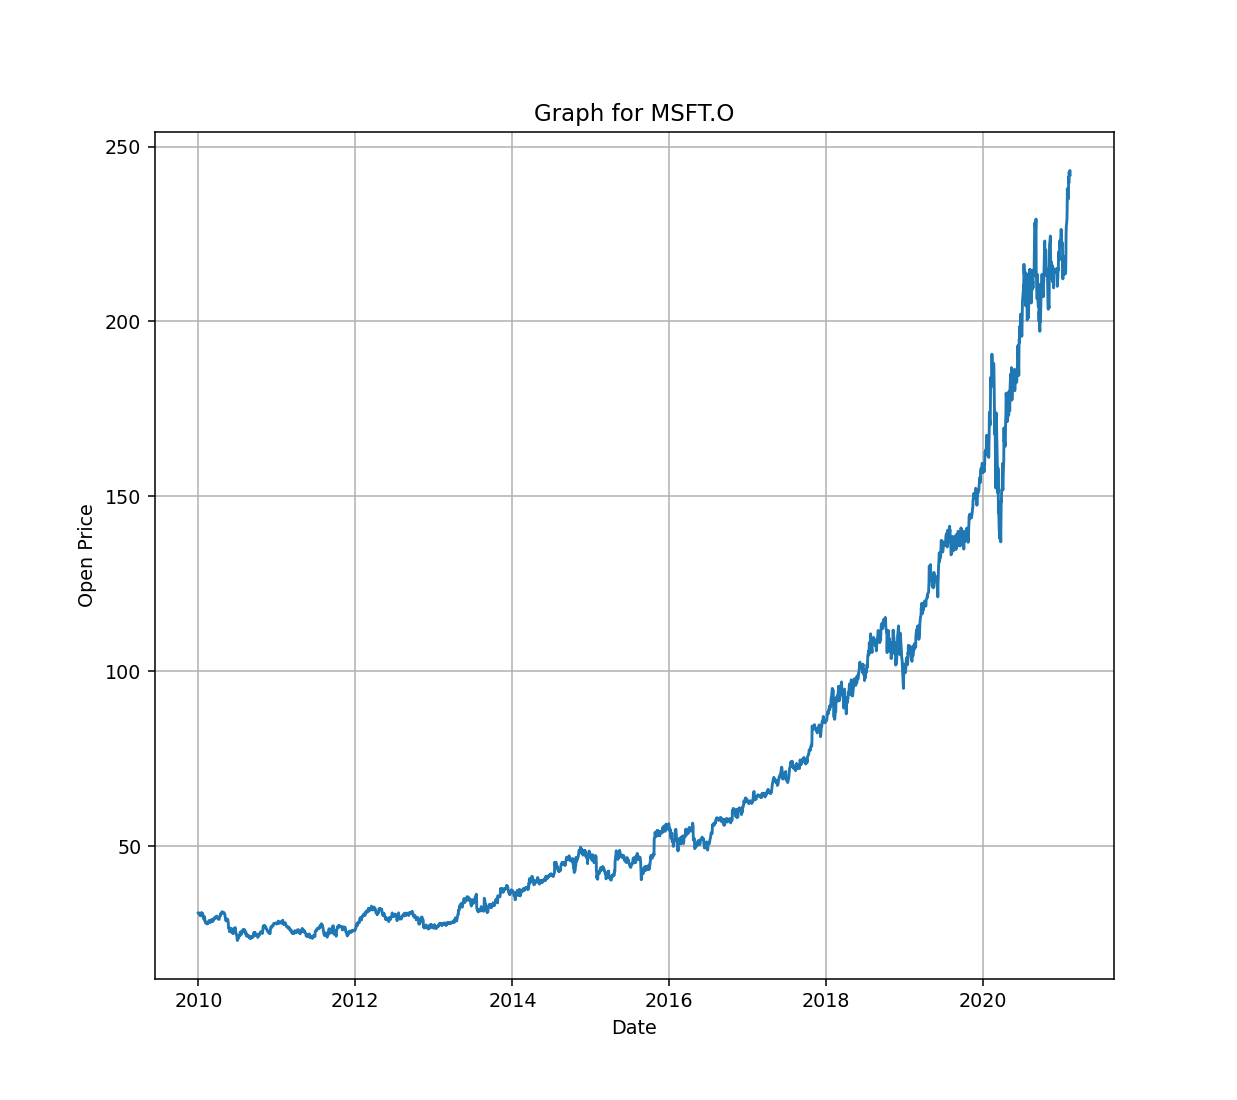

In [10]:
import matplotlib.pyplot as plt

%matplotlib notebook

fig = plt.figure(figsize=(9,8),dpi=100)
ax = plt.subplot2grid((3,3), (0, 0), rowspan=3, colspan=3)
titlename='Graph for '+ricName
ax.set_title(titlename)
ax.set_xlabel('Date')
ax.set_ylabel('Open Price')
ax.grid(True)
ax.plot(ohlc_dataframe.index, ohlc_dataframe.Open) 
plt.show()

### Generate a Histogram of the Daily Closing Price

A histogram might be useful to help review daily closing prices over time to see the spread or volatility, and also the type of distribution. We use the seaborn distplot method to plot the graph.


<IPython.core.display.Javascript object>


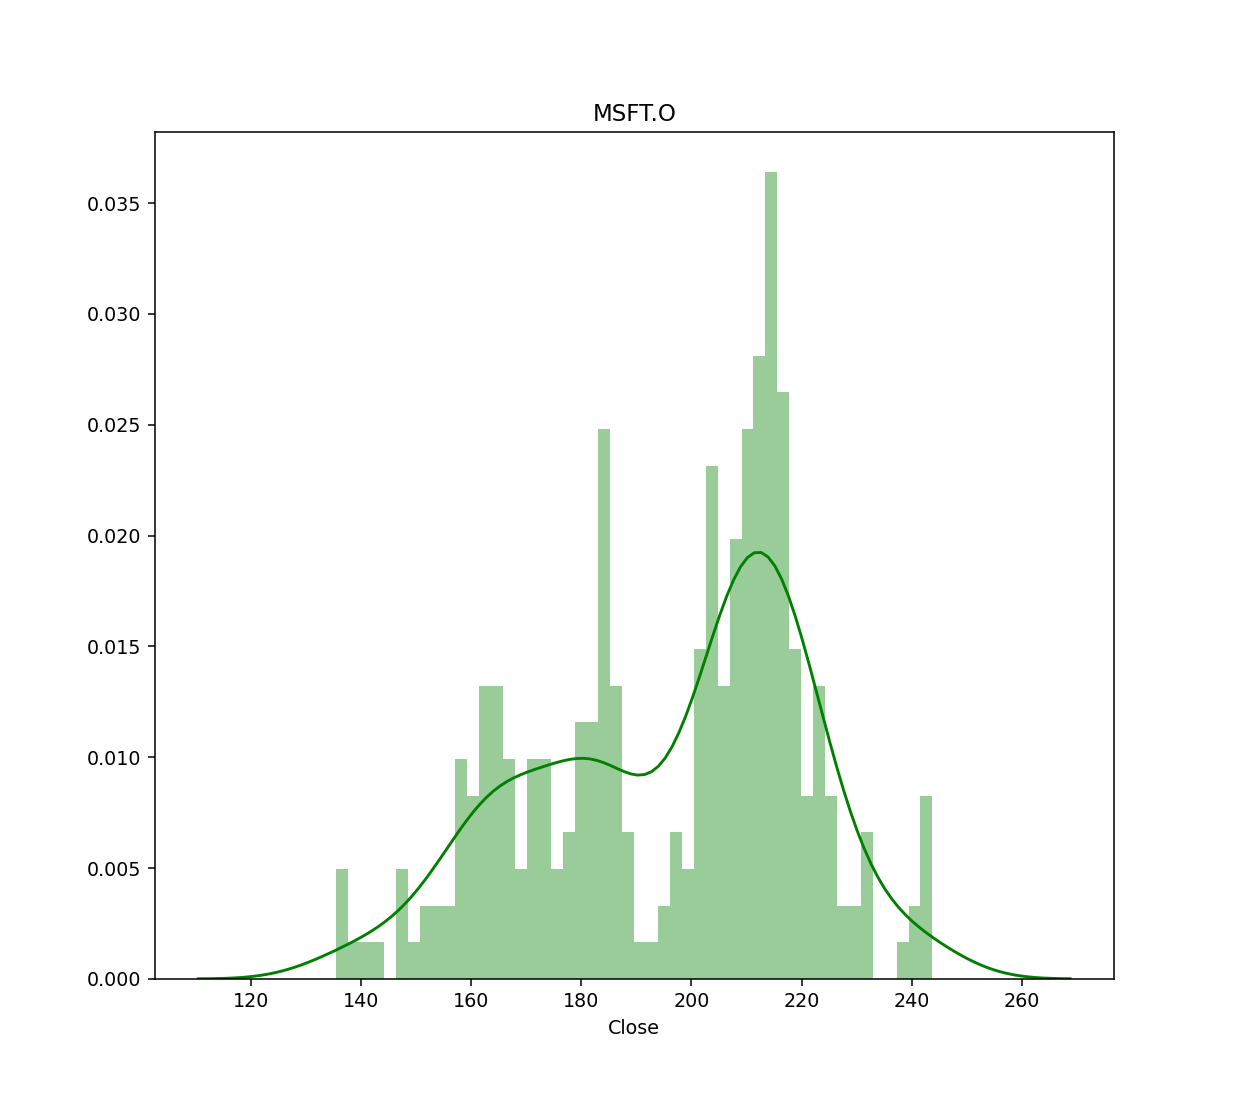

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,8),dpi=100)
dfPlot=ohlc_dataframe[['Close','Volume']].loc['2020-01-01':datetime.date.today(),:]
graph=sns.distplot(dfPlot.Close.dropna(), bins=50, color='green')
graph.set_title(ricName)
plt.show()

## Using mplfiance to generate CandleStick and OHLC chart.

Next step we will generate a CandleStick and OHLC chart using the new version [mplfinance library](https://github.com/matplotlib/mplfinance). We need to pass a dataframe which contain Open, High, Low and Close data to the mplfinance.plot function and specifiy the name of the chart you want to plot. 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2796 entries, 2009-12-31 to 2021-02-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2796 non-null   float64
 1   High    2796 non-null   float64
 2   Low     2796 non-null   float64
 3   Close   2796 non-null   float64
 4   Volume  2796 non-null   Int64  
dtypes: Int64(1), float64(4)
memory usage: 213.8 KB


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,158.78,160.7300,158.3300,160.62,22634546
2020-01-03,158.32,159.9450,158.0600,158.62,21121681
2020-01-06,157.08,159.1000,156.5100,159.03,20826702
2020-01-07,159.32,159.6700,157.3200,157.58,21881740
2020-01-08,158.93,160.8000,157.9491,160.09,27762026
...,...,...,...,...,...
2021-02-03,239.57,245.0900,239.2600,243.00,27158104
2021-02-04,242.66,243.2399,240.3700,242.01,25296100
2021-02-05,242.23,243.2800,240.4200,242.20,18054752


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279 entries, 2020-01-02 to 2021-02-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    279 non-null    float64
 1   High    279 non-null    float64
 2   Low     279 non-null    float64
 3   Close   279 non-null    float64
 4   Volume  279 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.1 KB


<IPython.core.display.Javascript object>


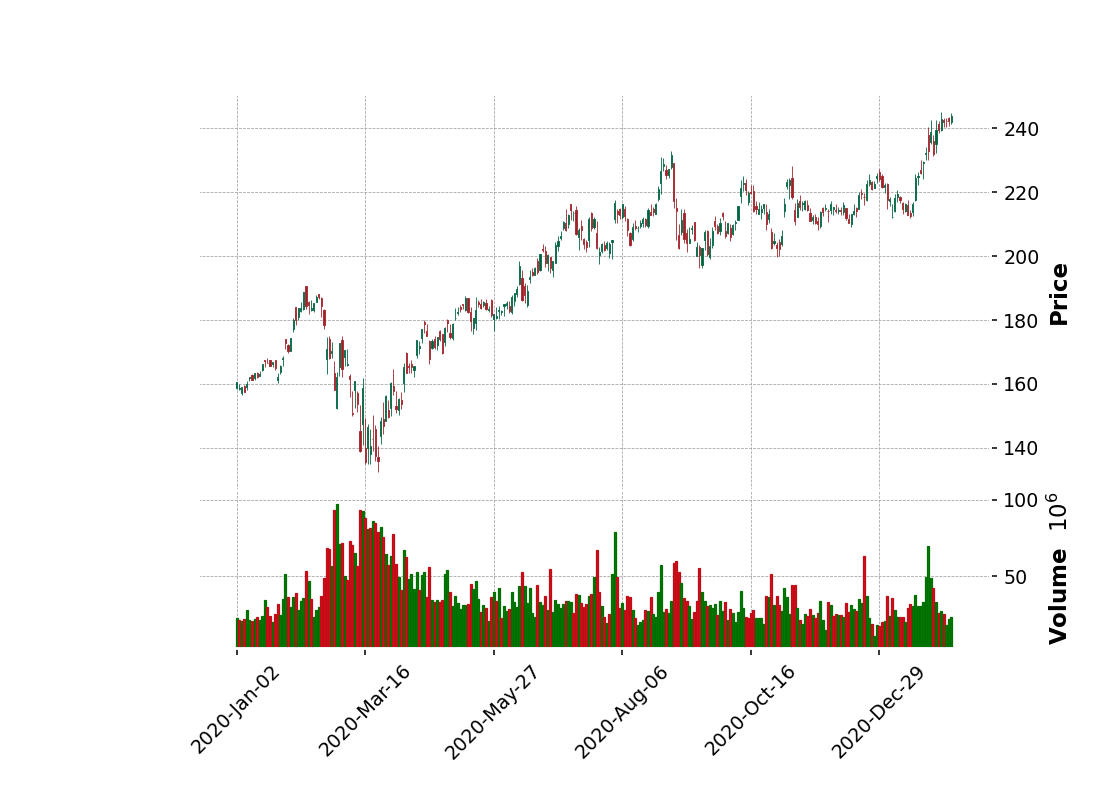

In [ ]:
import mplfinance as mpf
import datetime
%matplotlib notebook
ohlc_dataframe.info()
#Volume use Int64 it will returns fails when mplfinance.plot check the support type of the data.So we need to convert it to Int64 and remove na from the data frame.
#If you don't care about Volume you can drop it from the dataframe.
dfPlot=ohlc_dataframe.dropna().astype({col: 'int64' for col in ohlc_dataframe.select_dtypes('Int64').columns}).loc['2020-01-01':str(datetime.date.today())]     
display(dfPlot)
dfPlot.info()
mpf.plot(dfPlot.loc[:str(datetime.date.today()),:],type='candle',style='charles',volume=True)
#mpf.plt(dfPlot,type='lines',volume=True)

Display shorter period.

<IPython.core.display.Javascript object>


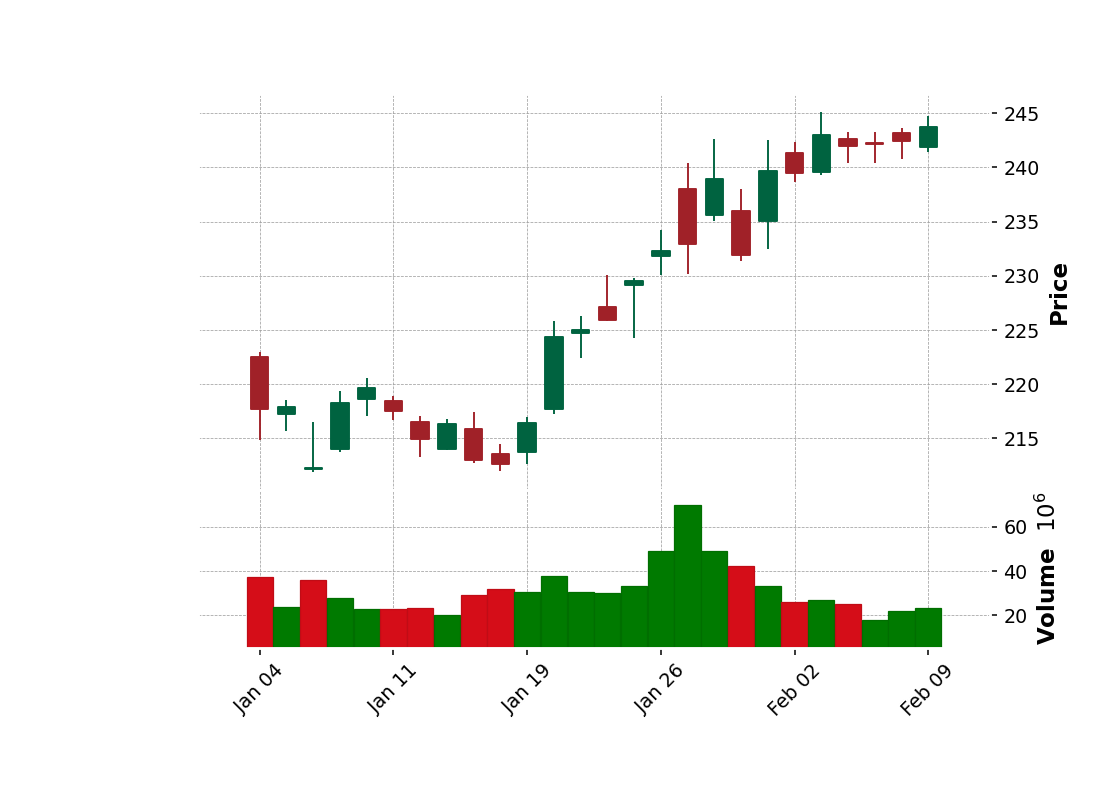

In [ ]:
tempPlot= ohlc_dataframe.dropna().astype({col: 'int64' for col in ohlc_dataframe.select_dtypes('Int64').columns}).loc['2021-01-01':str(datetime.date.today())] 
mpf.plot(tempPlot,type='candle',style='charles',volume=True)

From a candlestick chart(zoom the graph), a green candlestick indicates a day where the closing price was higher than the open(Gain), while a red candlestick indicates a day where the open was higher than the close (Loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is open and which the close). You can follow the instruction from the following [example](https://github.com/matplotlib/mplfinance/blob/master/examples/styles.ipynb) to change the color by passing you own stytle to the plot function. And as I said previously, a user can use Candlestick charts for technical analysis and use them to make trading decisions, depending on the shape, color, and position of the candles. We will not cover a technical analysis in this example.

## Plot OHLC chart

An OHLC chart is a type of bar chart that shows open, high, low, and closing prices for each period. OHLC charts are useful since they show the four major data points over a period, with the closing price being considered the most important by many traders.The chart type is useful because it can show increasing or decreasing momentum. When the open and close are far apart it shows strong momentum, and when the open and close are close together it shows indecision or weak momentum. The high and low show the full price range of the period, useful in assessing volatility. There several patterns traders watch for on OHLC charts[[8]](https://www.investopedia.com/terms/o/ohlcchart.asp).

To plot OHLC chart you can just change the type to 'ohlc'. It's quite easy when using mplfinance.

<IPython.core.display.Javascript object>


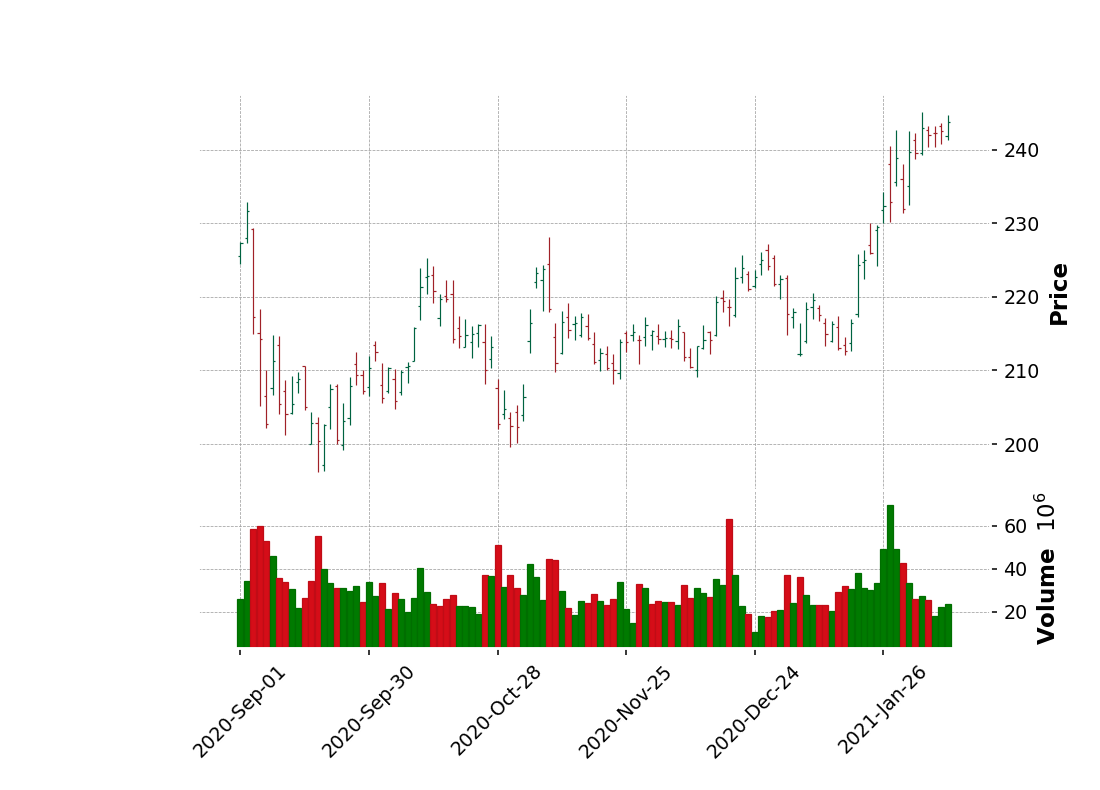

In [14]:
mpf.plot(dfPlot.loc['2020-09-01':str(datetime.date.today()),:],type='ohlc',style='charles',volume=True)

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,158.78,160.7300,158.3300,160.62,22634546
2020-01-03,158.32,159.9450,158.0600,158.62,21121681
2020-01-06,157.08,159.1000,156.5100,159.03,20826702
2020-01-07,159.32,159.6700,157.3200,157.58,21881740
2020-01-08,158.93,160.8000,157.9491,160.09,27762026
...,...,...,...,...,...
2021-02-03,239.57,245.0900,239.2600,243.00,27158104
2021-02-04,242.66,243.2399,240.3700,242.01,25296100
2021-02-05,242.23,243.2800,240.4200,242.20,18054752


<IPython.core.display.Javascript object>


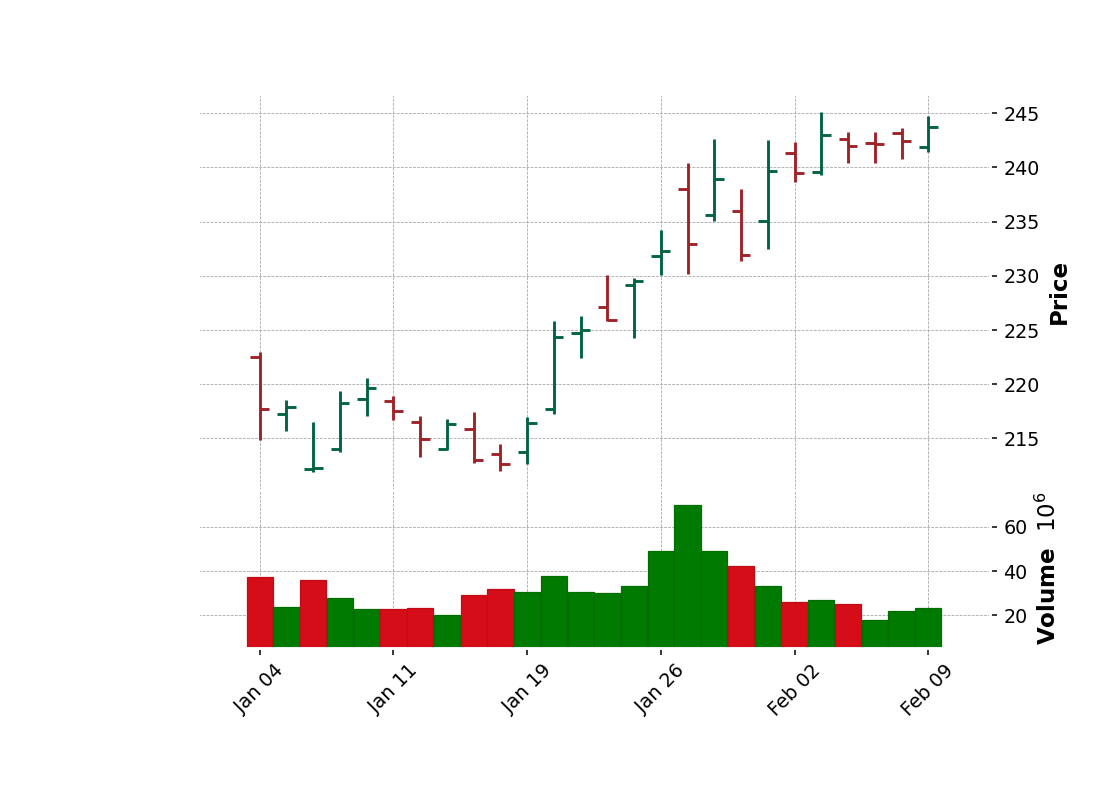

In [15]:
display(dfPlot)
mpf.plot(dfPlot.loc['2021-01-01':str(datetime.date.today()),:],type='ohlc',style='charles',volume=True)

## Adding plots to the basic mplfinance plot()

Sometimes you may want to plot additional data within the same figure as the basic OHLC or Candlestick plot. For example, you may want to add the results of a technical study or some additional market data.

This is done by passing information into the call to mplfinance.plot() using the addplot ("additional plot") keyword.
I will show you a sample of the additional plots by adding a line plot for the data from columns High and Low to the original OHLC chart.

<IPython.core.display.Javascript object>


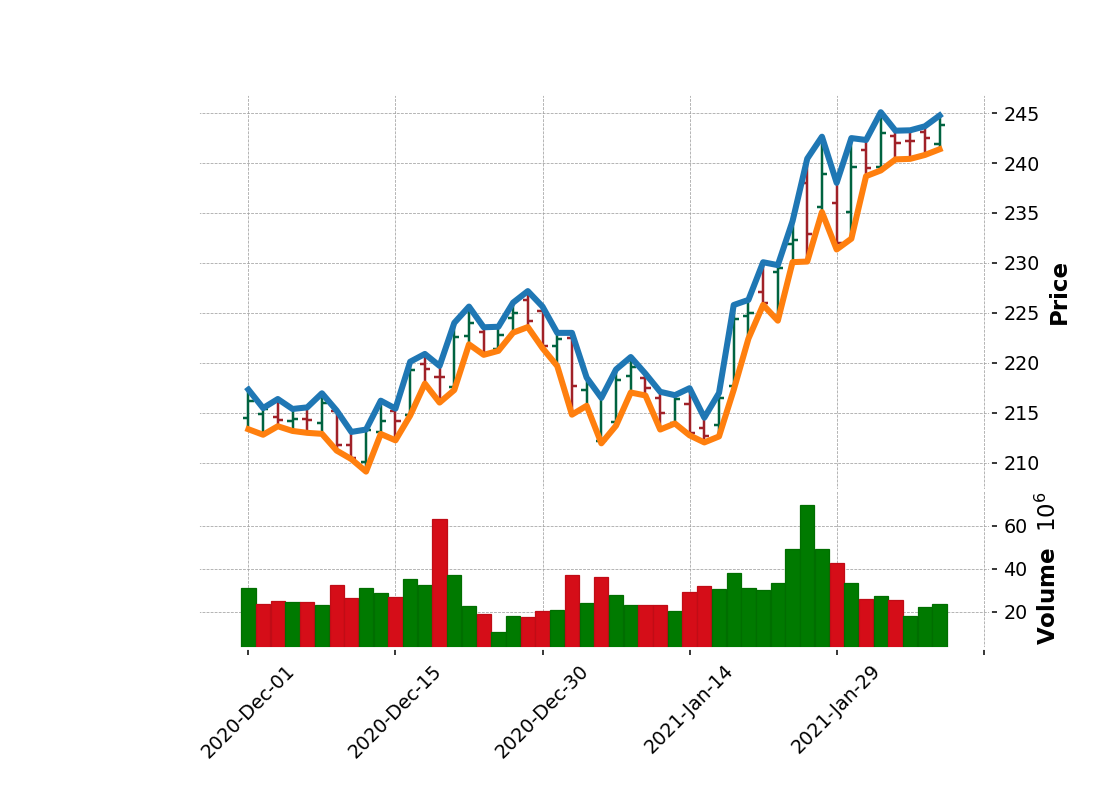

In [16]:
dfSubPlot = dfPlot.loc['2020-12-01':str(datetime.date.today()),:]
apdict = mpf.make_addplot(dfSubPlot[['High','Low']])
mpf.plot(dfSubPlot,type='ohlc',style='charles',volume=True,addplot=apdict)

## Add Simple Moving Average to the graph

Next steps, we will add a moving average (MA) to the CandleStick chart. MA is a widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random short-term price fluctuations. It is a trend-following or lagging, indicator because it is based on past prices. The two basic and commonly used moving averages are the simple moving average (SMA), which is the simple average of a security over a defined number of time periods, and the exponential moving average (EMA), which gives greater weight to more recent prices. Note that this example will use only builtin MA provided by the mplfinance. The most common applications of moving averages are to identify the trend direction and to determine support and resistance levels. 

Basically, mplfinance provides functionality for easily computing a moving averages. The following codes creating a 20-day moving average from the price provided in the the data frame, and plotting it alongside the stock. Moving averages lag behind current price action because they are based on past prices; the longer the time period for the moving average, the greater the lag. Thus, a 200-day MA will have a much greater degree of lag than a 20-day MA because it contains prices for the past 200 days.



<IPython.core.display.Javascript object>


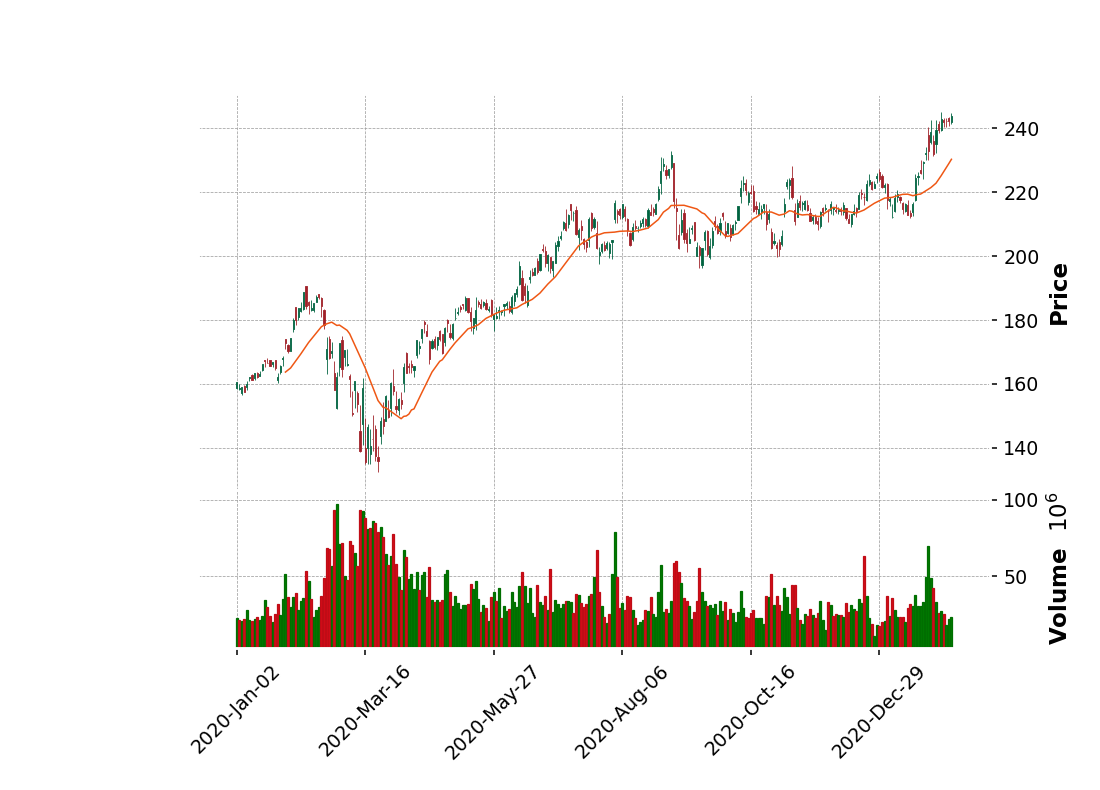

In [17]:
mpf.plot(dfPlot.loc[:str(datetime.date.today()),:],type='candle',style='charles',mav=(20),volume=True)

The length of the moving average to use depends on the trading objectives, with shorter moving averages used for short-term trading and longer-term moving averages more suited for long-term investors. The 50-day and 200-day MAs are widely followed by investors and traders, with breaks above and below this moving average considered to be important trading signals.

The following codes use to generated CandleStick chart with multiple periods of times for SMA (20-day,50-day,75-day, and 200-day).

<IPython.core.display.Javascript object>


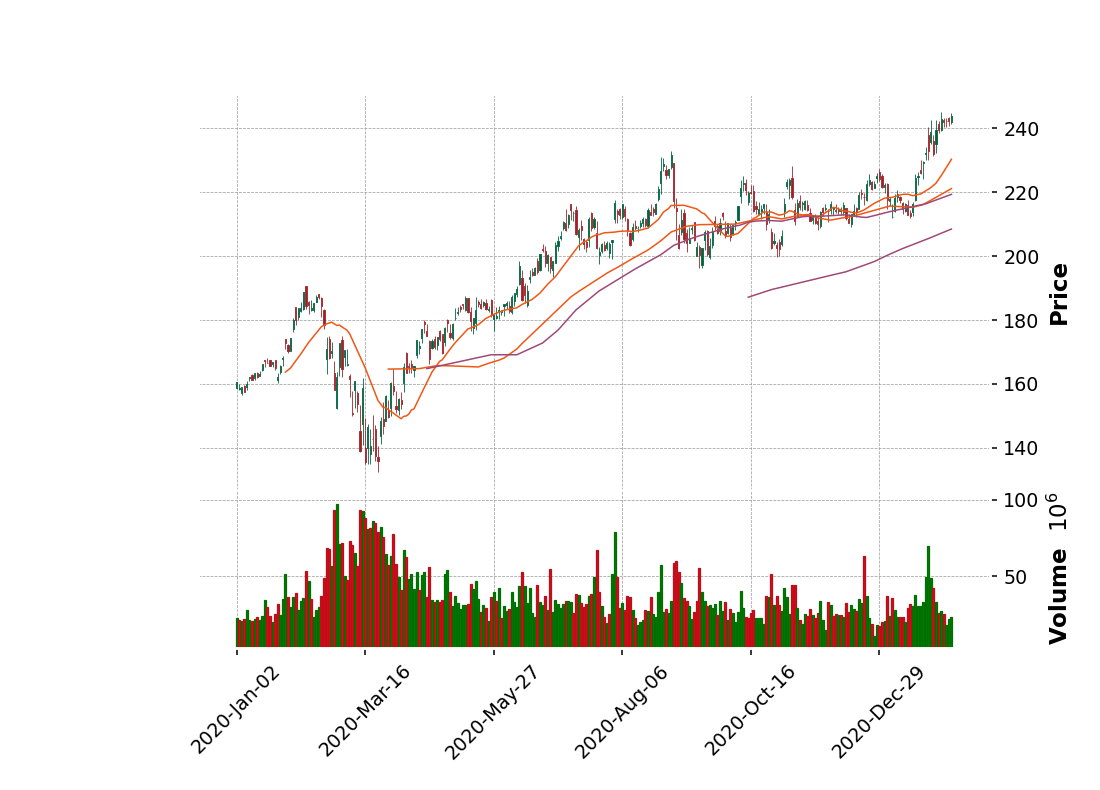

In [18]:
mpf.plot(dfPlot.loc[:str(datetime.date.today()),:],type='candle',style='charles',mav=(20,60,75,200),volume=True)

You can also calculate the moving average from your own method or algorithm using the original data from the dataframe and then add a subplot to the CandleStick charts by using add plot like the previous sample of OHLC charts.

## Generate Renko Chart

Based on information from [the investopedia page](https://www.investopedia.com/terms/r/renkochart.asp), a Renko chart is a type of chart, developed by the Japanese, that is built using price movement rather than both price and standardized time intervals like most charts are. It is thought to be named after the Japanese word for bricks, "renga," since the chart looks like a series of bricks. A new brick is created when the price moves a specified price amount, and each block is positioned at a 45-degree angle (up or down) to the prior brick. An up brick is typically colored white or green, while a down brick is typically colored black or red[[7]](https://www.investopedia.com/terms/r/renkochart.asp).

Renko charts filter out noise and help traders to more clearly see the trend, since all movements that are smaller than the box size are filtered out.Renko charts typically only use closing prices based on the chart time frame chosen. For example, if using a weekly time frame, then weekly closing prices will be used to construct the bricks[[7]](https://www.investopedia.com/terms/r/renkochart.asp).

<IPython.core.display.Javascript object>


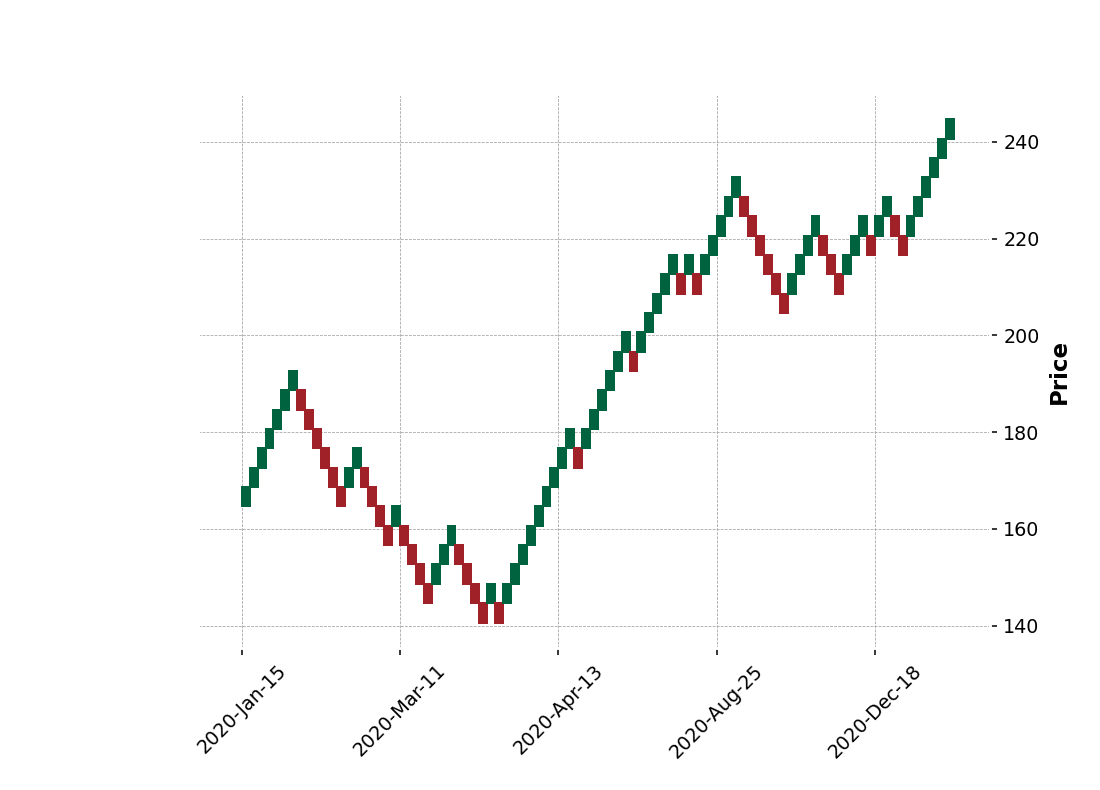

In [19]:
mpf.plot(dfPlot,type='renko',style='charles',renko_params=dict(brick_size=4))



## Summary

This article explains RDP users' alternate choices to retrieve such kind of the End of Day price or intraday datatime series data from the Refinitiv Data Platform. This article provides a sample code to use RDP Library for python to retrieve the RDP Historical Pricing service's intraday data. And then show how to utilize the data with the 3rd party library such as the mplfinance to plot charts like the CandleStick, OHLC, and Renko chart for stock price technical analysis. Using the RDP Library, users can specify a different kind of interval and adjustment behavior to retrieve more specific data and visualize the data on various charts. They can then use the charts to identify trading opportunities in price trends and patterns seen on charts. 

## References

1) [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis)

2) [mplfinance Library](https://github.com/matplotlib/mplfinance)

3) [CandleStick chart what is it?](https://www.investopedia.com/trading/candlestick-charting-what-is-it/)

4) [What Is a Moving Average Article.](https://www.investopedia.com/terms/m/movingaverage.asp)

5) [Seborn Tutorial](https://seaborn.pydata.org/tutorial/distributions.html)

6) [Matplotlib Examples](https://matplotlib.org/examples/pylab_examples/finance_demo.html)

7) [Renko Chart Definition and Uses](https://www.investopedia.com/terms/r/renkochart.asp)

8) [OHLC Chart](https://www.investopedia.com/terms/o/ohlcchart.asp)